In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc('xtick', labelsize=16) 
rc('ytick', labelsize=16)
rc('axes',labelsize=16, grid=True)
rc('font',size=16)

In [3]:
rc('figure', figsize=(13,8))

In [4]:
from brian2 import *

In [5]:
from brian2.units.constants import zero_celsius, gas_constant as R, faraday_constant as F

In [6]:
R*F

802223.42160352 * metre ** 2 * kilogram * second ** -1 * amp * kelvin ** -1 * mole ** -2

In [7]:
import input_factory as inpf

## The original HH model

In [8]:
T = 6*kelvin + zero_celsius

In [9]:
def Nernst(Ci,Co,z=1):
    return R*T*log(Co/Ci)/F/z

In [10]:
radius = 0.25*mm
length = 2*cm
area = 2*pi*radius*length
area

31.41592654 * mmetre2

In [11]:
def malpha_hh(V):
     return 0.1*(V+40*mV)/(1 - exp(-(V+40*mV)/10./mV))/mV/ms

In [12]:
defaultclock.dt = 0.01*ms
El = -54.5*mV
Nai,Nao = 20*mM,155*mM
Ki,Ko = 75*mM,3*mM


C = 1*uF/cm2*area

gna = 120*mS/cm2*area
gk = 36*mS/cm2*area
gl = 0.3*mS/cm2*area

# leak current
ileak_eqs = Equations("ileak = gl*(V-El) : amp")

# potassium current
Ek = Nernst(Ki,Ko)
ik_eqs = Equations("""
ik = gk*n**4*(V - Ek) : amp
# -- gating -- 
dn/dt = nalpha*(1-n) - nbeta*n : 1
nalpha = 0.01*(V + 55*mV)/(1 - exp(-(V + 55*mV)/10.0/mV))/mV/ms : 1/second
nbeta = 0.125*exp(-(V + 65*mV)/80/mV)/ms: Hz
""")

# sodium current
Ena = Nernst(Nai,Nao)
ina_eqs = Equations("""
ina = gna*m**3*h*(V-Ena) : amp
# -- gating -- 
dm/dt = malpha*(1-m) - mbeta*m : 1
dh/dt = halpha*(1-h) - hbeta*h : 1
# -- activation gate rates -- 
malpha = 0.1*(V+40*mV)/(1 - exp(-(V+40*mV)/10./mV))/mV/ms : 1/second
mbeta = 4*exp(-(V+65*mV)/18/mV)/ms : 1/second
# -- inactivation -- 
halpha = 0.07*exp(-(V+65*mV)/20/mV)/ms : 1/second
hbeta = 1/(1 + exp(-(V+35*mV)/10/mV))/ms : 1/second
""")

# Full set of equations
hh_eqs = Equations("""
dV/dt = (I_stim - ileak - ina - ik)/C : volt
stim_amp : 1
I_stim =  stim_amp*input_current(t,i): amp
""") + ik_eqs + ina_eqs + ileak_eqs

In [13]:
input_current = inpf.get_step_current(300, 800, 1*ms, 1.0*uA)

In [14]:
print("Membrane capacitance: {}".format(C))
print("Max Na conductance: {}".format(gna))

Membrane capacitance: 3.141592653589793e-07
Max Na conductance: 0.037699111843077525


In [15]:
print("Sodium reversal potential Ena = {}".format(Ena))
print("Potassium reversal potential EK = {}".format(Ek))

Sodium reversal potential Ena = 0.04925781949322867
Potassium reversal potential EK = -0.07743095106583486


In [16]:
start_scope()

G = NeuronGroup(1, hh_eqs, method='exponential_euler')
G.set_states(dict(V=-65.2*mV, m=0.05,h=0.6,n=0.3))

In [17]:
G.stim_amp = 0 
run(20*ms)
#states = G.get_states()
stateM = StateMonitor(G, variables=True,record=True)
store() # Store the initialized state of the model
#store()

### Excitability properties

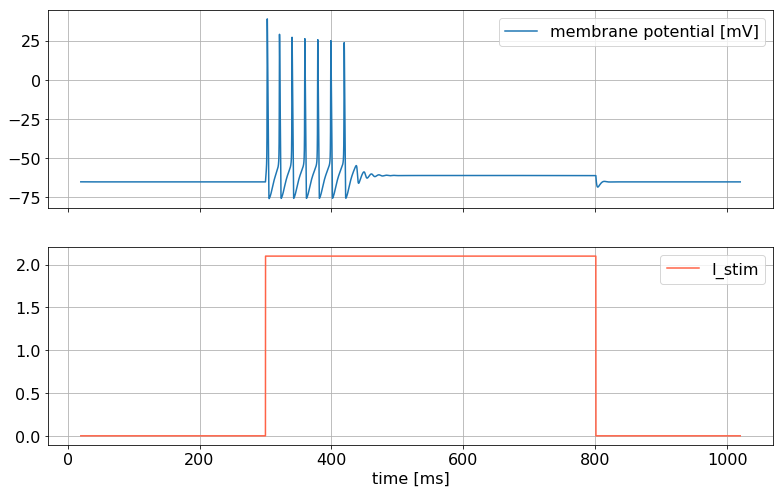

In [18]:
restore() # restore the initialized state and run new experiment
G.stim_amp = 2.1 # try to find threshold for (1) single spike, (2) sustained firing
run(1*second)
f,axs = subplots(2,1,sharex=True)
axs[0].plot(stateM.t/ms, stateM.V[0]/mV,label='membrane potential [mV]')
axs[1].plot(stateM.t/ms, stateM.I_stim[0]/uA,c='tomato',label='I_stim')
axs[0].legend(); axs[1].legend()
xlabel('time [ms]'); 

### Rebound spike

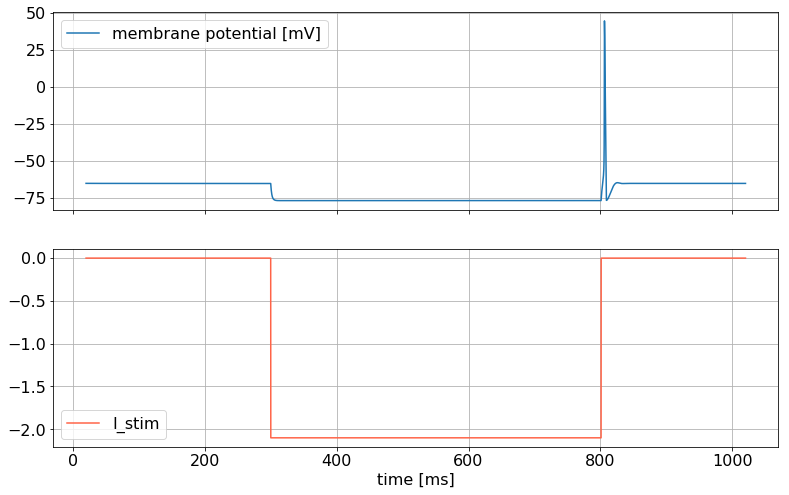

In [19]:
restore() # restore the initialized state and run new experiment
G.stim_amp = -2.1
run(1*second)
f,axs = subplots(2,1,sharex=True)
axs[0].plot(stateM.t/ms, stateM.V[0]/mV,label='membrane potential [mV]')
axs[1].plot(stateM.t/ms, stateM.I_stim[0]/uA,c='tomato',label='I_stim')
axs[0].legend(); axs[1].legend()
xlabel('time [ms]'); 

In [20]:
start_scope()

Ndummy = 200
Vv = linspace(-90,40,Ndummy)*mV

dummy_eqs = """dV/dt = (V0-V)/ms: volt
               V0:volt
            """

dummyG = NeuronGroup(Ndummy,
                     Equations(dummy_eqs)+ik_eqs+ina_eqs,method='euler')
dummyG.V0 = Vv
dummyG.V = Vv
M = StateMonitor(dummyG,variables=True,record=True)
run(defaultclock.dt)

Text(0.5,0,'V [mV]')

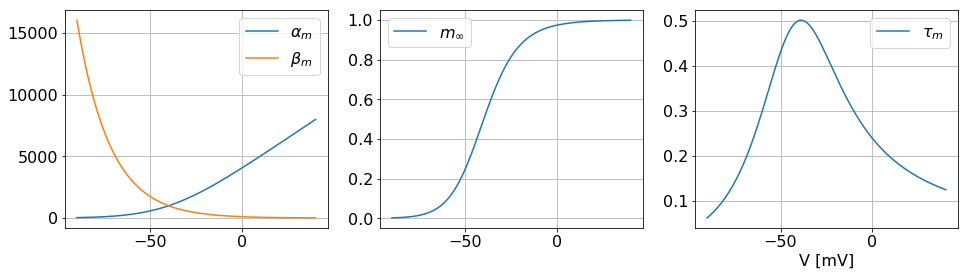

In [21]:
f,axs = subplots(1,3,sharex=True,figsize=(16,4))
axs[0].plot(Vv/mV, M.malpha,label=r'$\alpha_m$')
axs[0].plot(Vv/mV, M.mbeta,label=r'$\beta_m$')
axs[0].legend()

axs[1].plot(Vv/mV, M.malpha/(M.malpha+M.mbeta),label=r'$m_\infty$')
axs[1].legend()

axs[2].plot(Vv/mV, 1/(M.malpha+M.mbeta)/ms,label=r'$\tau_m$')
axs[2].legend()


xlabel('V [mV]')


**Exercise:**
 - [ ] Make graphs like the one above, but for $n$ and $h$ gating variables

  ## Neurons of the VCN (Rothman & Manis *J Neurophysiol* 2003)

In [22]:
import pandas as pd

In [23]:
soma_diameter = 21*um
soma_area = pi*soma_diameter**2
C = 0.9*uF/cm2*soma_area
C

12.46898124 * pfarad

In [24]:
Ek = -70*mV
Ena = +55*mV
Eh = -43*mV
Elk = -65*mV

### Sodium current

In [25]:
# sodium current
ina_eqs_vcn = Equations("""
ina_vcn = gnabar*m**3*h*(V-Ena) : amp
# -- gating -- 
dm/dt = (minf-m)/mtau : 1
dh/dt = (hinf-h)/htau : 1
minf= 1/(1 + exp(-(V+38*mV)/7/mV)) : 1
hinf = 1/(1 + exp((V+65*mV)/6/mV)) : 1
mtau = 10*ms/(5*exp((V+60*mV)/18/mV) + 36*exp(-(V+60*mV)/25/mV)) + 0.04*ms : second
htau = 100*ms/(7*exp((V+60*mV)/11/mV) + 10*exp(-(V+60*mV)/25/mV)) + 0.6*ms : second
""")

### Kht (high-threshold К current)


In [26]:
ikht_eqs = Equations("""
ikht = gkhtbar*(phi*n**2 + (1-phi)*p)*(V-Ek) : amp
phi =  0.85 : 1

dn/dt = (ninf - n)/ntau: 1
dp/dt = (pinf-p)/ptau : 1

ninf = 1/(1 + exp(-(V/mV+15)/5))**0.5 : 1
pinf = 1/(1 + exp(-(V/mV+23)/6)) : 1
ntau = (100/(11*exp((V/mV+60.0)/24.0) + 21.0*exp(-(V/mV+60.0)/23.0)) + 0.7)*ms : second
ptau = (100/(4*exp((V/mV+60.0)/32.0) + 5.0*exp(-(V/mV+60.0)/22.0)) + 5.0)*ms   : second
""")

### Klt (low-threshold К current)

In [27]:
iklt_eqs = Equations("""
iklt = gkltbar*(w**4)*z*(V-Ek) : amp

dw/dt = (winf-w)/wtau : 1
dz/dt = (zinf-z)/ztau : 1

winf = (1 + exp(-(V/mV+48)/6.0))**-0.25 : 1
wtau = (100/(6.0*exp((V/mV+60.0)/6.0) + 16.0*exp(-(V/mV+60.0)/45.0)) + 1.5)*ms: second

zinf = (1-0.5)*(1 + exp((V/mV+71)/10.0))**-1 + 0.5 : 1
ztau = (1000/(exp((V/mV+60)/20.0) + exp(-(V/mV+60)/8.0)) + 50)*ms : second
""")

### Ih (hyperpolarization-activated current)

In [28]:
ih_eqs = Equations("""
ih = ghbar*r*(V-Eh) : amp
dr/dt = (rinf-r)/rtau : 1
rinf = 1/(1 + exp((V/mV+76)/7)) : 1
rtau = (10**5/(237*exp((V/mV+60)/12) + 17*exp(-(V/mV+60)/14)) + 25)*ms : second
""")


### Full vcn equations:

In [29]:
vcn_equations = Equations("""
dV/dt = (I_stim - ileak - ina_vcn - ikht - iklt - ih)/C : volt
ileak = glk*(V-Elk) : amp
stim_amp : 1
I_stim =  stim_amp*input_current(t,i): amp
""") + ina_eqs_vcn + ikht_eqs + iklt_eqs + ih_eqs

### Conductances in nS

In [30]:
rm_params = pd.read_csv("Rothman-Manis-2003-table1.csv", index_col=0)
rm_params

,Ic,It,I_II,II_I,II
gnabar,1000.0,1000.0,1000,1000.0,1000
gkhtbar,150.0,80.0,150,150.0,150
gkltbar,0.0,0.0,20,35.0,200
gkabar,0.0,65.0,0,0.0,0
ghbar,0.5,0.5,2,3.5,20
glk,2.0,2.0,2,2.0,2


In [31]:
def convert_rm_table_units(key):
    return {k:v*nS for k,v in dict(rm_params[key]).items()}

## Setting up the neurons

In [32]:
start_scope()

G_typeIc =  NeuronGroup(1, vcn_equations, namespace=convert_rm_table_units('Ic'), method='exponential_euler')

In [33]:
input_current = inpf.get_step_current(300, 450, 1*ms, 1.0*pA)

In [34]:
run(200*ms)
MIc = StateMonitor(G_typeIc, variables=True, record=True)
store()


In [35]:
restore()
G_typeIc.stim_amp = 50
run(0.5*second)
vplus = MIc.V[0][:]
#plot(MIc.t/ms, MIc.V[0]/mV)

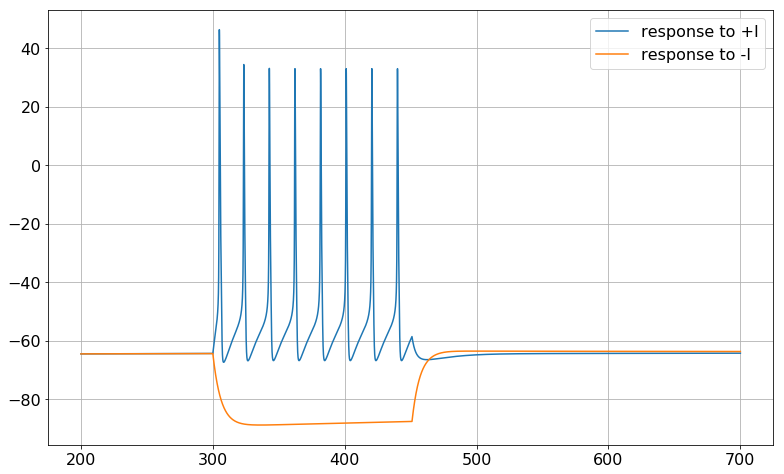

In [40]:
restore()
G_typeIc.stim_amp = -50
run(0.5*second)
plot(MIc.t/ms, vplus/mV)
plot(MIc.t/ms, MIc.V[0]/mV)
legend(('response to +I', 'response to -I '))

In [37]:
start_scope()
G_typeII =  NeuronGroup(1, vcn_equations, namespace=convert_rm_table_units('II'), method='exponential_euler')

In [38]:
run(200*ms)
MII = StateMonitor(G_typeII, variables=True, record=True)
store()

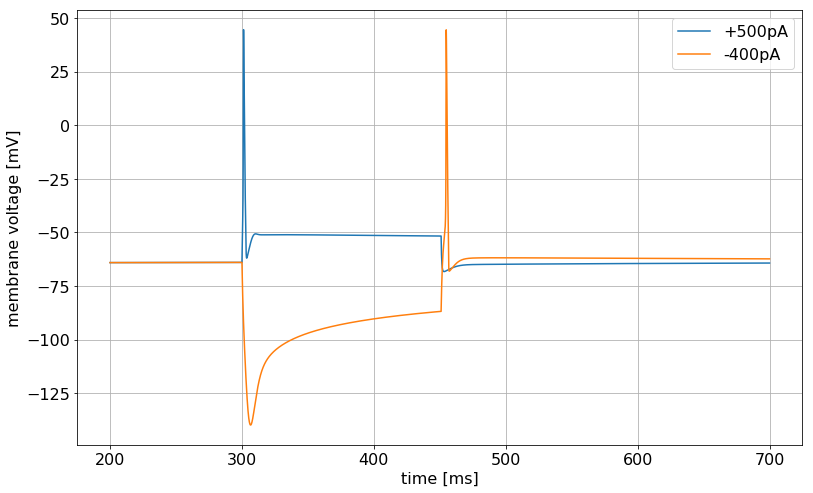

In [41]:
restore()
G_typeII.stim_amp = 500
run(0.5*second)
plot(MII.t/ms, MII.V[0]/mV, label='+500pA')

restore()
G_typeII.stim_amp = -400
run(0.5*second)
plot(MII.t/ms, MII.V[0]/mV,label='-400pA')
xlabel('time [ms]')
ylabel('membrane voltage [mV]')

legend()

**Exersice:**
   - Explain, why the membrane voltage sags during hyperpolarizing stimulus
   - why does it sag more in the typeII model?
   - test if typeI neuron can encode input current amplitude in spiking frequency
   - which current is the slowest?

**Themes for projects (may want to choose one)**
   - Investigate bifurcations of the resting state of the typeI and typeII neurons
   - Investigate response of typeI and typeII models to stimulation with noisy injected current or injected conductance. You may want to read Brian2 documentation on how to do this kind of simulation